In [1]:
# 4章 バイアスと公平性：再犯のモデリング

In [2]:
import pandas as pd
import numpy as np

compas_df = pd.read_csv('drive/MyDrive/data/compas-scores-two-years.csv')

In [3]:
compas_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


<Axes: title={'center': 'Decile Score Histogram by Race'}, xlabel='race', ylabel='% with Decile Score'>

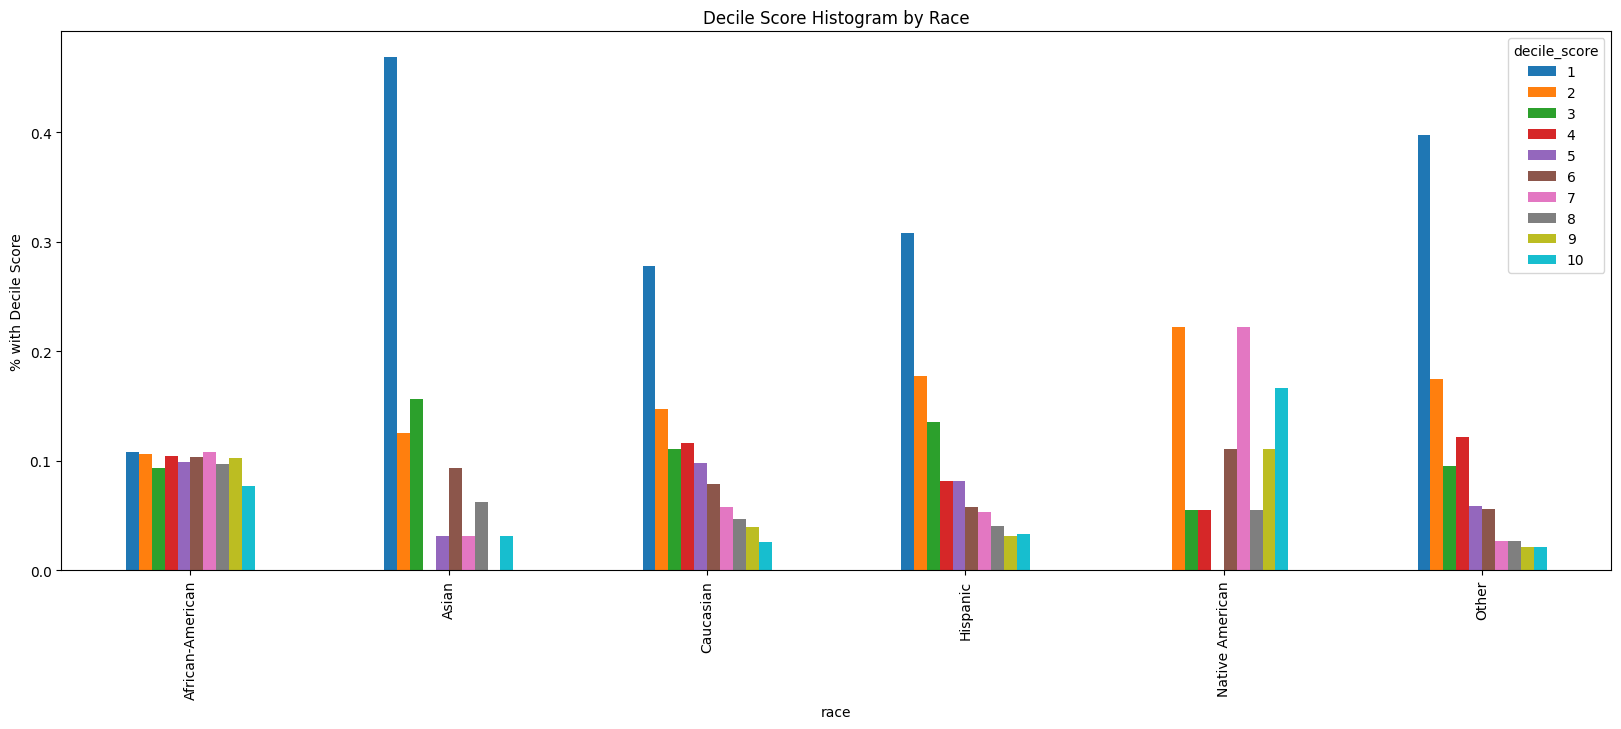

In [4]:
compas_df.groupby('race')['decile_score'].value_counts(
    normalize=True
).unstack().plot(
    kind='bar', figsize=(20, 7),
    title='Decile Score Histogram by Race', ylabel='% with Decile Score'
)

In [5]:
compas_df.groupby('race')['decile_score'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,5.368777,2.831122,1.0,3.00,5.0,8.00,10.0
Asian,32.0,2.937500,2.601953,1.0,1.00,2.0,3.50,10.0
Caucasian,2454.0,3.735126,2.597926,1.0,1.00,3.0,5.00,10.0
Hispanic,637.0,3.463108,2.599100,1.0,1.00,3.0,5.00,10.0
Native American,18.0,6.166667,2.975389,2.0,3.25,7.0,8.75,10.0
Other,377.0,2.949602,2.350895,1.0,1.00,2.0,4.00,10.0


In [6]:
# 探索的データ分析

In [7]:
compas_df.groupby('race')['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,0.514340,0.499862,0.0,0.0,1.0,1.0,1.0
Asian,32.0,0.281250,0.456803,0.0,0.0,0.0,1.0,1.0
Caucasian,2454.0,0.393643,0.488657,0.0,0.0,0.0,1.0,1.0
Hispanic,637.0,0.364207,0.481585,0.0,0.0,0.0,1.0,1.0
Native American,18.0,0.555556,0.511310,0.0,0.0,1.0,1.0,1.0
Other,377.0,0.352785,0.478472,0.0,0.0,0.0,1.0,1.0


In [8]:
# 人種が 'Native American' や 'Asian' の場合、それらを 'Other' に変更
compas_df.loc[compas_df['race'].isin(['Native American', 'Asian']), 'race'] = 'Other'

<Axes: title={'center': 'Actual Recidivism Rates by Race'}, xlabel='race'>

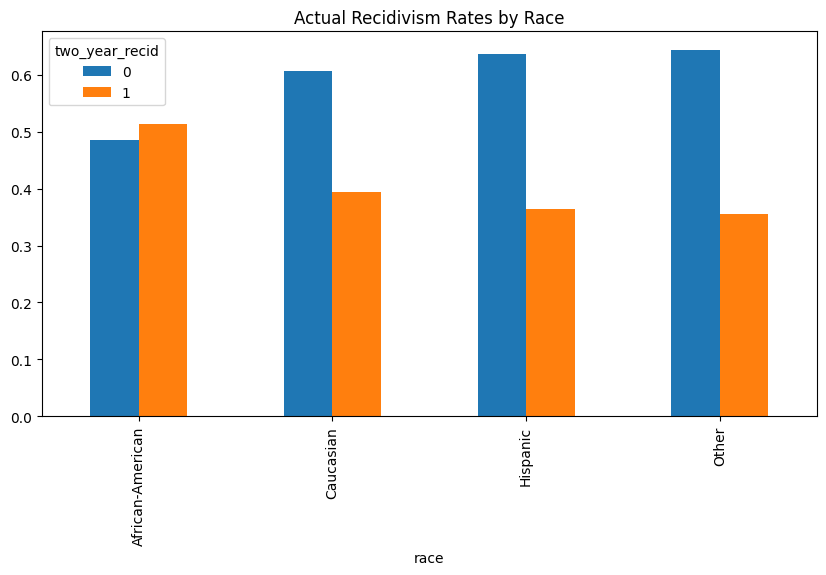

In [9]:
compas_df.groupby('race')['two_year_recid'].value_counts(
    normalize=True
).unstack().plot(
    kind='bar', figsize=(10, 5), title='Actual Recidivism Rates by Race'
)

<Axes: title={'center': '% of Charge Degree'}, xlabel='Charge Degree', ylabel='%'>

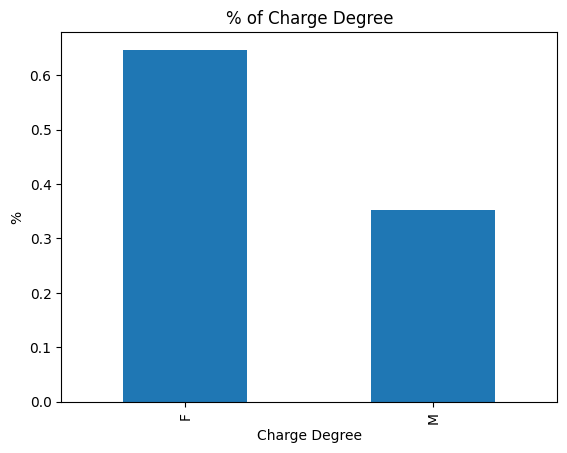

In [10]:
compas_df['c_charge_degree'].value_counts(normalize=True).plot(
    kind='bar', title='% of Charge Degree', ylabel='%', xlabel='Charge Degree'
)

<Axes: title={'center': 'Histogram of Age'}, xlabel='Age', ylabel='Frequency'>

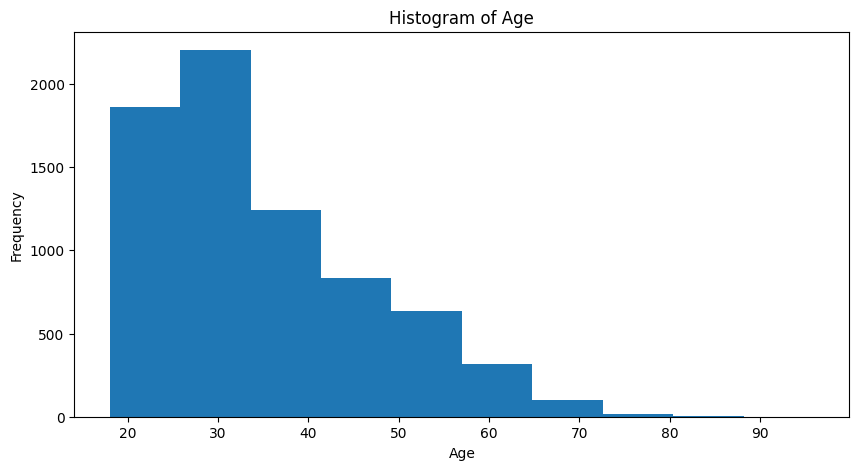

In [11]:
compas_df['age'].plot(
    title='Histogram of Age', kind='hist', xlabel='Age', figsize=(10, 5)
)

<Axes: title={'center': 'Histogram of Priors Count'}, xlabel='Priors', ylabel='Frequency'>

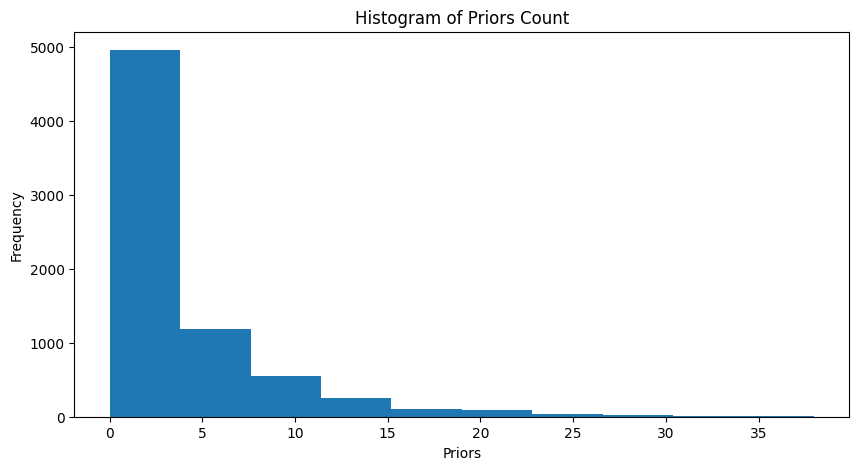

In [12]:
compas_df['priors_count'].plot(
    title='Histogram of Priors Count', kind='hist', xlabel='Priors', figsize=(10, 5)
)

In [13]:
# 統計的パリティー
# あるクラスに属するかどうか（再犯するかどうか）というモデルの予測結果が、
# センシティブな特徴量に依存しないこと

In [14]:
# 等価オッズ
# モデルが陽性と正しく予測した割合と陽性と誤って予測した割合が、
# センシティブな特徴量のグループ間でどれだけ一致するか

In [15]:
# ベースラインモデルの構築

In [16]:
compas_df[["juv_fel_count", "juv_misd_count", "juv_other_count"]].describe()

,juv_fel_count,juv_misd_count,juv_other_count
count,7214.000000,7214.000000,7214.000000
mean,0.067230,0.090934,0.109371
std,0.473972,0.485239,0.501586
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,20.000000,13.000000,17.000000


In [17]:
compas_df['juv_count'] = compas_df[["juv_fel_count", "juv_misd_count", "juv_other_count"]].sum(axis=1)

compas_df[['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'juv_count']].describe()

,juv_fel_count,juv_misd_count,juv_other_count,juv_count
count,7214.000000,7214.000000,7214.000000,7214.000000
mean,0.067230,0.090934,0.109371,0.267535
std,0.473972,0.485239,0.501586,0.952763
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,20.000000,13.000000,17.000000,21.000000


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split up our data
X_train, X_test, y_train, y_test, race_train, race_test = train_test_split(compas_df.drop('two_year_recid', axis=1),
                                                    compas_df['two_year_recid'],
                                                    compas_df['race'],
                                                    stratify=compas_df['two_year_recid'],
                                                    test_size=0.3,
                                                    random_state=0)

# our static classifier
classifier = RandomForestClassifier(max_depth=10, n_estimators=20, random_state=0)

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler


categorical_features = ['race', 'sex', 'c_charge_degree']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary'))
])

numerical_features = ["age", "priors_count"]
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

# transformも実行される
preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
])

clf_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])


clf_tree.fit(X_train, y_train)

unaware_y_preds = clf_tree.predict(X_test)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=unaware_y_preds))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70      1189
           1       0.63      0.56      0.59       976

    accuracy                           0.65      2165
   macro avg       0.65      0.64      0.65      2165
weighted avg       0.65      0.65      0.65      2165



In [21]:
# 実際の再犯率
y_test.groupby(race_test).mean()

,two_year_recid
race,
African-American,0.514652
Caucasian,0.407162
Hispanic,0.327778
Other,0.345324


In [22]:
# 予測再犯率
pd.Series(unaware_y_preds, index=y_test.index).groupby(race_test).mean()

,0
race,
African-American,0.508242
Caucasian,0.285146
Hispanic,0.255556
Other,0.381295


In [23]:
# バイアスを考慮したモデルの構築

In [24]:
# compas_df.corrwith(compas_df['race'] == 'African-American').sort_values()
#
# age              -0.179095
# juv_count         0.111835
# two_year_recid    0.131200
# priors_count      0.202897
# dtype: float64

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,32.740801,10.858391,18.0,25.0,30.0,38.00,77.0
Caucasian,2454.0,37.726569,12.761373,18.0,27.0,35.0,47.75,83.0
Hispanic,637.0,35.455259,11.877783,19.0,26.0,33.0,43.00,96.0
Other,427.0,35.131148,11.634159,19.0,25.0,33.0,43.00,76.0


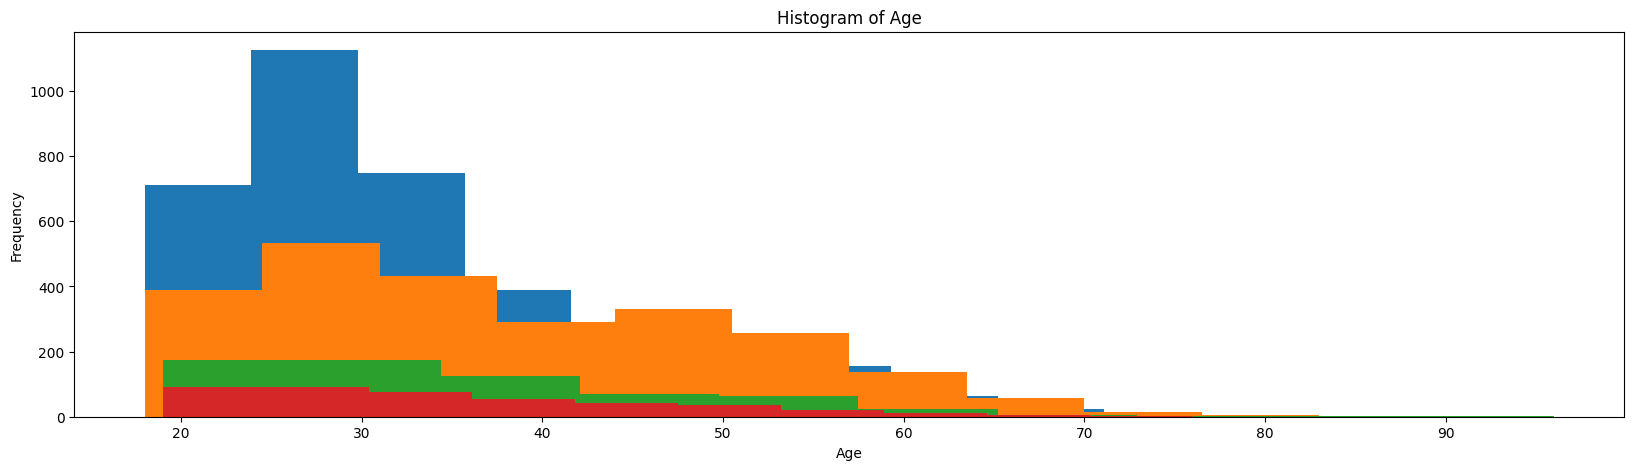

In [25]:
# 4つの人種全体で年齢は比較的類似しており、
# 平均、標準偏差、中央値もほぼ同じ
compas_df.groupby('race')['age'].plot(
    figsize=(20,5),
    kind='hist', xlabel='Age', title='Histogram of Age'
)
compas_df.groupby('race')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,4.438853,5.579835,0.0,1.0,2.0,6.0,38.0
Caucasian,2454.0,2.586797,3.798803,0.0,0.0,1.0,3.0,36.0
Hispanic,637.0,2.252747,3.647673,0.0,0.0,1.0,2.0,26.0
Other,427.0,2.016393,3.695856,0.0,0.0,1.0,2.5,31.0


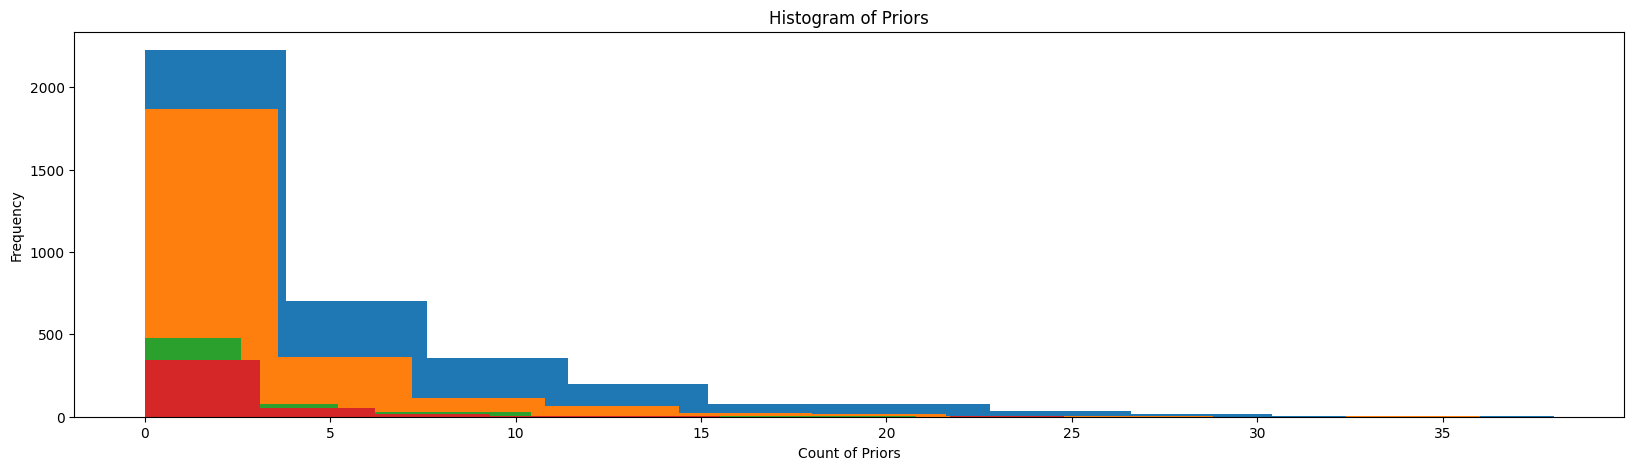

In [26]:
# アフリカ系アメリカ人の前科件数の中央値と平均値は、
# 他のグループのほぼ2倍となっている
compas_df.groupby('race')['priors_count'].plot(
    figsize=(20,5),
    kind='hist', xlabel='Count of Priors', title='Histogram of Priors'
)
compas_df.groupby('race')['priors_count'].describe()

In [27]:
from sklearn.preprocessing import PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class NormalizeColumnByLabel(BaseEstimator, TransformerMixin):
    def __init__(self, col, label):
        self.col = col
        self.label = label
        self.transformers = {}

    def fit(self, X, y=None):
        for group in X[self.label].unique():
            self.transformers[group] = PowerTransformer(
                method='yeo-johnson', standardize=True
            )
            self.transformers[group].fit(
                X.loc[X[self.label]==group][self.col].values.reshape(-1, 1)
            )
        return self

    def transform(self, X, y=None):
        C = X.copy()
        for group in X[self.label].unique():
            C.loc[X[self.label]==group, self.col] = self.transformers[group].transform(
                X.loc[X[self.label]==group][self.col].values.reshape(-1, 1)
            )
        return C

<ipython-input-27-0b7f48dc98bf>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.19091358 -1.19091358  1.26869417 ... -0.10439575  0.41212247
  0.73386571]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  C.loc[X[self.label]==group, self.col] = self.transformers[group].transform(


,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,2604.0,-8.868141e-17,1.000192,-1.394037,-0.549932,-0.092417,0.784661,2.276224
Caucasian,1700.0,1.097162e-16,1.000294,-1.190914,-1.190914,-0.104396,0.733866,2.293665
Hispanic,457.0,-9.911838e-17,1.001096,-1.124116,-1.124116,0.098333,0.620238,2.060623
Other,288.0,1.572816e-16,1.001741,-0.921525,-0.921525,-0.921525,0.878567,1.871600


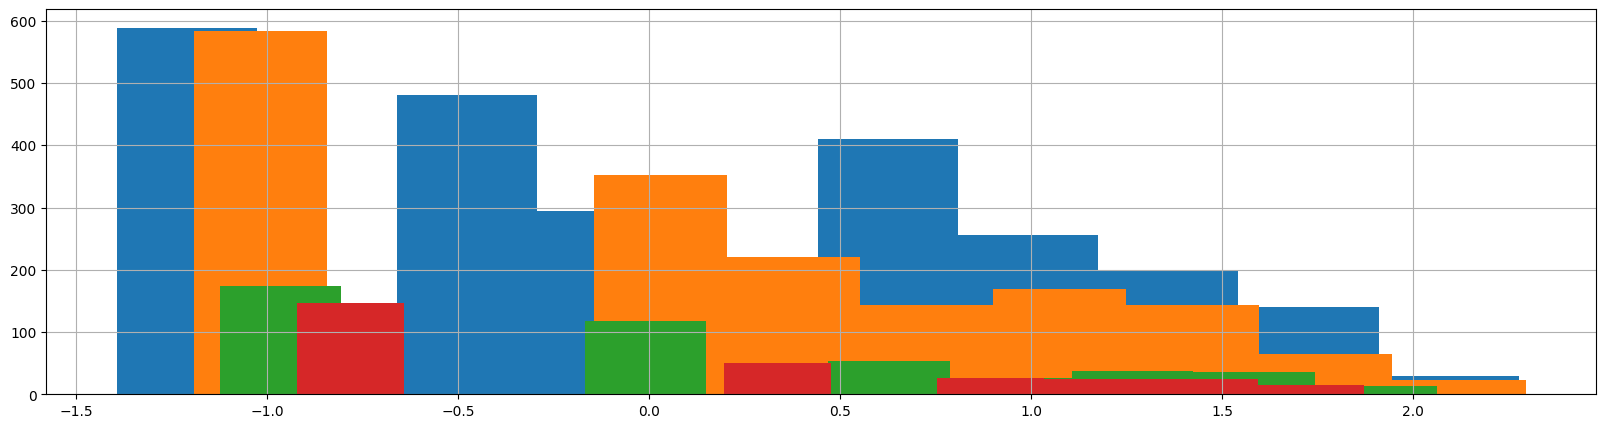

In [28]:
n = NormalizeColumnByLabel(col='priors_count', label='race')

X_train_normalized = n.fit_transform(X_train, y_train)

X_train_normalized.groupby('race')['priors_count'].hist(figsize=(20,5))
X_train_normalized.groupby('race')['priors_count'].describe()

In [29]:
# 最初のバイアスを考慮したモデル
clf_tree_aware = Pipeline(steps=[
    ('normalize_priors', NormalizeColumnByLabel(col='priors_count', label='race')),
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

clf_tree_aware.fit(X_train, y_train)

aware_y_preds = clf_tree_aware.predict(X_test)

print(classification_report(y_true=y_test, y_pred=aware_y_preds))

<ipython-input-27-0b7f48dc98bf>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.19091358 -1.19091358  1.26869417 ... -0.10439575  0.41212247
  0.73386571]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  C.loc[X[self.label]==group, self.col] = self.transformers[group].transform(


              precision    recall  f1-score   support

           0       0.67      0.73      0.70      1189
           1       0.63      0.56      0.59       976

    accuracy                           0.66      2165
   macro avg       0.65      0.65      0.65      2165
weighted avg       0.65      0.66      0.65      2165



<ipython-input-27-0b7f48dc98bf>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.62023814  1.97137986  0.92428519  1.95253475 -1.12411644 -1.12411644
  0.62023814  1.72059699 -1.12411644  0.09833278 -1.12411644 -1.12411644
  0.09833278  0.62023814  0.92428519  1.72059699 -1.12411644  0.09833278
 -1.12411644 -1.12411644  0.09833278  1.12830757  0.62023814  0.62023814
 -1.12411644  0.92428519  0.09833278 -1.12411644  1.62019152  0.09833278
  0.09833278  0.92428519 -1.12411644  0.92428519 -1.12411644 -1.12411644
  1.97137986 -1.12411644  0.09833278  0.09833278  0.62023814 -1.12411644
  0.09833278 -1.12411644 -1.12411644  0.62023814  1.62019152 -1.12411644
  0.92428519 -1.12411644  1.76150988 -1.12411644 -1.12411644  1.72059699
  1.48234303  0.62023814  0.62023814  0.62023814 -1.12411644  0.92428519
  0.09833278  1.48234303  0.09833278  1.76150988  0.09833278  1.2769125
  0.09833278 -1.12411644  0.62023814 -1.1241